In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from tqdm import tqdm
from collections import Counter, defaultdict
from PIL import Image
import copy
import logging
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union

from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader
from argoverse.data_loading.object_classes import OBJ_CLASS_MAPPING_DICT
from argoverse.data_loading.object_label_record import ObjectLabelRecord
from argoverse.utils.calibration import Calibration
from argoverse.utils.frustum_clipping import generate_frustum_planes

import argoverse
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader

In [2]:
plt.rcParams["figure.figsize"] = (8.0, 6.0)
master_dir = "/Users/yuqingz/Documents/Argo"

In [3]:
data_dir = master_dir + "/argoverse-tracking-v2/train4"
loader = ArgoverseTrackingLoader(data_dir)

# Process the data

In [4]:
loader.print_all()

#images: 13716
#lidar: 624


In [5]:
data = loader[0]
lidar_pts = data.get_lidar(0)
print(type(lidar_pts))
print(lidar_pts.shape)

<class 'numpy.ndarray'>
(83538, 3)


In [6]:
lidar_pts[:5,:5]

array([[ 0.83155596, -4.333962  , -0.44668972],
       [ 1.1308284 , -8.15739   ,  1.4476095 ],
       [ 0.3167106 , -8.232344  ,  1.348437  ],
       [ 0.8488307 , -6.7133756 , -0.29473507],
       [ 0.31154633, -8.262333  , -0.07621026]], dtype=float32)

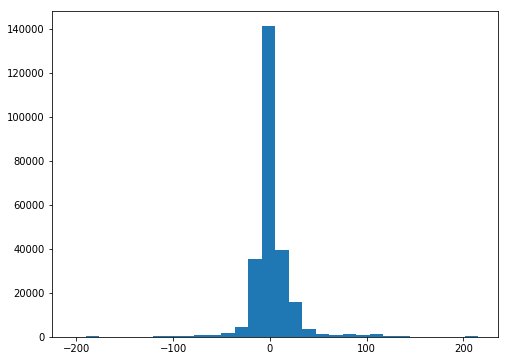

In [7]:
tmp = lidar_pts.copy()
plt.hist(tmp.flatten(), bins=30)
plt.show()

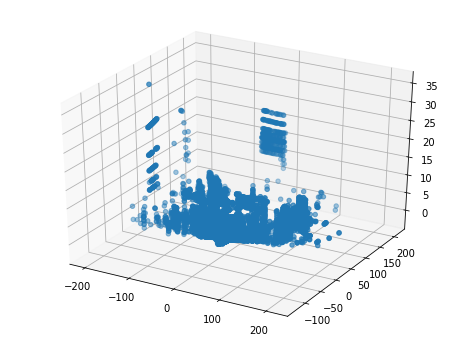

In [8]:
ax = plt.axes(projection='3d')

x = lidar_pts[:,0]
y = lidar_pts[:,1]
z = lidar_pts[:,2]
ax.scatter3D(x, y, z);

In [9]:
for i, data in enumerate(loader):
    for lidar_idx in range(len(data.lidar_list)):
        lidar_pts = data.get_lidar(lidar_idx)
        if i == 0 and lidar_idx <= 8:
            print(lidar_pts.shape)

(83538, 3)
(83356, 3)
(83228, 3)
(83036, 3)
(82622, 3)
(82271, 3)
(82214, 3)
(81937, 3)
(81022, 3)


## Precomputed detection results

In [12]:
import os
import json

In [13]:
precompute_detect_dir = master_dir + '/ptrcnn_detect_format/training/'

In [14]:
logs = os.listdir(data_dir)[1:]
logs

['2c07fcda-6671-3ac0-ac23-4a232e0e031e',
 '2bc6a872-9979-3493-82eb-fb55407473c9',
 '15c802a9-0f0e-3c87-b516-a3fa02f1ecb0',
 '49d66e75-3ce6-316b-b589-f659c7ef5e6d']

In [15]:
curr_log = logs[0]

In [16]:
label_dir = data_dir + '/' + curr_log + '/per_sweep_annotations_amodal/'
detect_dir = precompute_detect_dir + curr_log + '/per_sweep_annotations_amodal/'

In [17]:
label_files = os.listdir(label_dir)
label_files.sort()
detect_files = os.listdir(detect_dir)
detect_files.sort()
print(len(label_files))
print(len(detect_files))

156
156


In [18]:
all([label_files[i] == detect_files[i] for i in range(len(label_files))])

True

In [19]:
label_data = json.load(open(label_dir + label_files[0], 'rb'))
detect_res = json.load(open(detect_dir + detect_files[0], 'rb'))

In [20]:
label_data[0]

{'center': {'x': -7.6245048051244035,
  'y': 3.0934946878647764,
  'z': 0.36075467652451465},
 'rotation': {'x': 0.0,
  'y': 0.0,
  'z': -0.9995840359441817,
  'w': 0.028840164450656906},
 'length': 4.08,
 'width': 1.9023620151463432,
 'height': 1.7157508844031,
 'track_label_uuid': 'af15f20b-939e-497f-a9d7-8cbb41b03194',
 'timestamp': 315976036019687000,
 'label_class': 'VEHICLE'}

In [21]:
detect_res[0]

{'track_label_uuid': None,
 'tracked': True,
 'occlusion': 0,
 'timestamp': 315976036019687000,
 'label_class': 'VEHICLE',
 'score': 0.9465071558952332,
 'center': {'x': 30.208826065063477,
  'y': -1.5987598896026611,
  'z': 1.536407470703125},
 'rotation': {'w': 0.9999172740298639,
  'x': 0.0,
  'y': 0.0,
  'z': -0.012862546275376202},
 'height': 1.5435740947723389,
 'width': 1.5955026149749756,
 'length': 3.807525873184204}

In [22]:
Counter([label_data[k]['label_class'] for k in range(len(label_data))])

Counter({'VEHICLE': 22,
         'BUS': 1,
         'PEDESTRIAN': 6,
         'ON_ROAD_OBSTACLE': 2,
         'LARGE_VEHICLE': 1,
         'BICYCLIST': 1})

In [23]:
Counter([detect_res[k]['label_class'] for k in range(len(detect_res))])

Counter({'VEHICLE': 3})

In [24]:
len(label_data)

33

In [25]:
len(detect_res)

3

The detection result appears to only detect vehicle and pedestrian. There are false positives as well. Groupings of label in GCBS paper: (Car), (Truck, Construction Vehicle), (Bus, Trailer), (Barrier), (Motorcycle, Bicycle), (Pedestrian, Traffic Cone).

In [26]:
set([item['track_label_uuid'] for item in detect_res])

{None}

In [28]:
# for i in range(len(detect_files)):
#     tmp_res = json.load(open(detect_dir + detect_files[i], 'rb'))
#     print(set([item['occlusion'] for item in tmp_res]))

In [29]:
type(detect_res[0]['timestamp'])

int

## Re-run tracker

In [26]:
track_dir = './argoverse_cbgs_kf_tracker/temp_files/train-split-track-preds-maxage15-minhits5-conf0.3/'

In [27]:
track_dir = track_dir + curr_log + '/per_sweep_annotations_amodal/'
track_files = os.listdir(track_dir)
track_files.sort()

In [28]:
print(track_files[0])
print(detect_files[0])
print(label_files[0])

tracked_object_labels_315976036019687000.json
tracked_object_labels_315976036019687000.json
tracked_object_labels_315976036019687000.json


In [29]:
track_res = json.load(open(track_dir + detect_files[0], 'rb'))

In [31]:
track_res[0]

{'center': {'x': -19.273963928222408,
  'y': -8.998175621032772,
  'z': 0.38227087259293313},
 'rotation': {'x': 0.0,
  'y': 0.0,
  'z': -0.9997181750203589,
  'w': 0.02373964056094809},
 'length': 0.6531398296356201,
 'width': 0.6125357151031494,
 'height': 1.6976591348648071,
 'track_label_uuid': 'a32980c258454fcdb8106cff8075cc0b',
 'timestamp': 315976036019687000,
 'label_class': 'PEDESTRIAN'}

In [32]:
len(label_data)

33

In [33]:
len(track_res)

117

In [34]:
Counter([track_res[k]['track_label_uuid'] for k in range(len(track_res))])

Counter({'a32980c258454fcdb8106cff8075cc0b': 1,
         '66534c7dbb1547c49085ca1a71d5924b': 1,
         '5a59a00413834a4d87b3db0caf4222e0': 1,
         '2b8a0e779f2c44ce845a9874f90ace09': 1,
         'a2779e69ae0444ff9c3325aef88f0f34': 1,
         '1868232b1f9d4742bb0b4f337da7ba1a': 1,
         '5f7030c4d4de48a38cc7b360d1426df6': 1,
         '783c7e8b70d343dd9aacbf52d2811114': 1,
         'fc5f4f66c3484e54a6c5ccad3da1665a': 1,
         '39b00336702f4a74b780cb38bca69c6c': 1,
         'e93459372c5048b9a91f365ec105d8ef': 1,
         '431262d7f70e4a56a706aa8bb5759136': 1,
         '90ef73f7aee94e6aa58a65b96f5be339': 1,
         '127c5ad571b84da7b184315f49aff764': 1,
         '9ca6265924994a84bc4407d478372dac': 1,
         '5c5336b66b0b4193a62f9e54f0a509e2': 1,
         '3a48416156d74165a035d6dc3538a867': 1,
         'f2f0464a7a1c4c0eb8f3fa168f9429e3': 1,
         'bb3c6a7471a546789200175c518772d4': 1,
         'ecd836ae12d84bb1bf32cf8879d69852': 1,
         'beaa3548ef634c328ac8d0c9b9ee6f

## Visualize detection

In [30]:
import argoverse.visualization.visualization_utils as viz_util
import argoverse.data_loading.object_label_record as lbl

In [31]:
camera = loader.CAMERA_LIST[0]
data = loader.get(curr_log)
city_name = data.city_name

(-10.0, 10.0, -10.0, 10.0)

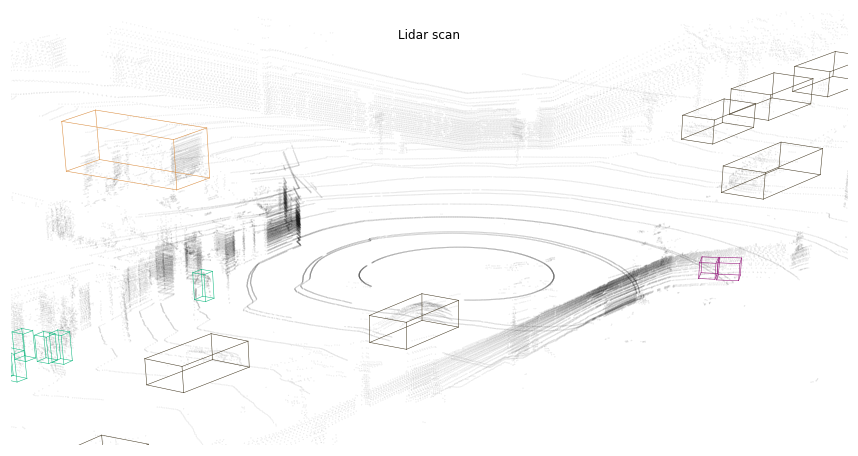

In [32]:
f2 = plt.figure(figsize=(15, 8))
ax2 = f2.add_subplot(111, projection='3d')
viz_util.draw_point_cloud(ax2, 'Lidar scan', data, 0)
ax2.axis('off')

(-10.0, 10.0, -10.0, 10.0)

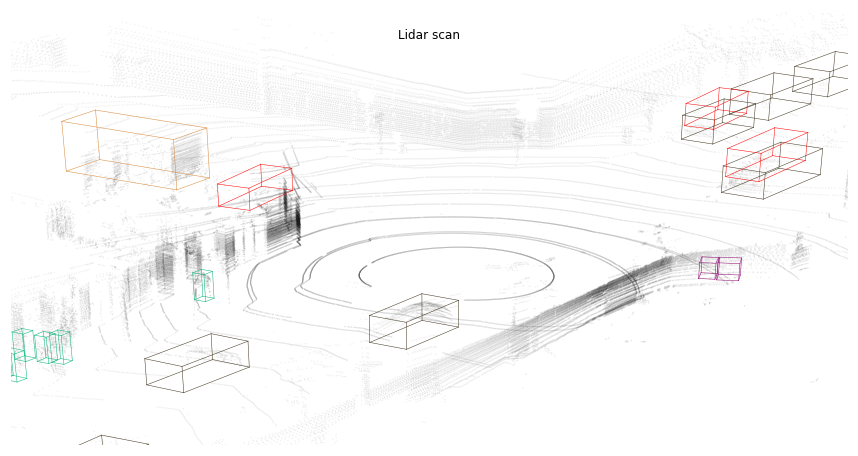

In [33]:
f2 = plt.figure(figsize=(15, 8))
ax2 = f2.add_subplot(111, projection='3d')
viz_util.draw_point_cloud(ax2, 'Lidar scan', data, 0)
for k in range(len(detect_res)):
    pred_label = lbl.json_label_dict_to_obj_record(detect_res[k])
    viz_util.draw_box(ax2, pred_label.as_3d_bbox().T, color='red') 
ax2.axis('off')

### Overlay on images

In [34]:
def make_grid_ring_camera2(argoverse_data, idx, pred_labels):

    f, ax = plt.subplots(3, 3, figsize=(20, 15))

    camera = "ring_front_left"
    img = argoverse_data.get_image_sync(idx, camera=camera)
    objects = argoverse_data.get_label_object(idx)
    calib = argoverse_data.get_calibration(camera)
    img_vis = Image.fromarray(show_image_with_boxes2(img, objects, pred_labels, calib))
    ax[0, 0].imshow(img_vis)
    ax[0, 0].set_title("Ring Front Left")
    ax[0, 0].axis("off")

    camera = "ring_front_center"
    img = argoverse_data.get_image_sync(idx, camera=camera)
    objects = argoverse_data.get_label_object(idx)
    calib = argoverse_data.get_calibration(camera)
    img_vis = Image.fromarray(show_image_with_boxes2(img, objects, pred_labels, calib))
    ax[0, 1].imshow(img_vis)
    ax[0, 1].set_title("Right Front Center")
    ax[0, 1].axis("off")

    camera = "ring_front_right"
    img = argoverse_data.get_image_sync(idx, camera=camera)
    objects = argoverse_data.get_label_object(idx)
    calib = argoverse_data.get_calibration(camera)
    img_vis = Image.fromarray(show_image_with_boxes2(img, objects, pred_labels, calib))
    ax[0, 2].imshow(img_vis)
    ax[0, 2].set_title("Ring Front Right")
    ax[0, 2].axis("off")

    camera = "ring_side_left"
    img = argoverse_data.get_image_sync(idx, camera=camera)
    objects = argoverse_data.get_label_object(idx)
    calib = argoverse_data.get_calibration(camera)
    img_vis = Image.fromarray(show_image_with_boxes2(img, objects, pred_labels, calib))
    ax[1, 0].imshow(img_vis)
    ax[1, 0].set_title("Ring Side Left")
    ax[1, 0].axis("off")

    ax[1, 1].axis("off")

    camera = "ring_side_right"
    img = argoverse_data.get_image_sync(idx, camera=camera)
    objects = argoverse_data.get_label_object(idx)
    calib = argoverse_data.get_calibration(camera)
    img_vis = Image.fromarray(show_image_with_boxes2(img, objects, pred_labels, calib))
    ax[1, 2].imshow(img_vis)
    ax[1, 2].set_title("Ring Side Right")
    ax[1, 2].axis("off")

    camera = "ring_rear_left"
    img = argoverse_data.get_image_sync(idx, camera=camera)
    objects = argoverse_data.get_label_object(idx)
    calib = argoverse_data.get_calibration(camera)
    img_vis = Image.fromarray(show_image_with_boxes2(img, objects, pred_labels, calib))
    ax[2, 0].imshow(img_vis)
    ax[2, 0].set_title("Ring Rear Left")
    ax[2, 0].axis("off")

    ax[2, 1].axis("off")

    camera = "ring_rear_right"
    img = argoverse_data.get_image_sync(idx, camera=camera)
    objects = argoverse_data.get_label_object(idx)
    calib = argoverse_data.get_calibration(camera)
    img_vis = Image.fromarray(show_image_with_boxes2(img, objects, pred_labels, calib))
    ax[2, 2].imshow(img_vis)
    ax[2, 2].set_title("Ring Rear Right")
    ax[2, 2].axis("off")

    return f, ax


def show_image_with_boxes2(img, objects, 
                          pred_labels, calib):
    """Show image with 2D bounding boxes."""
    img1 = np.copy(img)

    h, w = np.shape(img1)[0:2]
    planes = generate_frustum_planes(calib.K, calib.camera)
    assert planes is not None

    for obj in objects:
        if obj.occlusion == 100:
            continue
        box3d_pts_3d = obj.as_3d_bbox()
        uv_cam = calib.project_ego_to_cam(box3d_pts_3d)

        img1 = obj.render_clip_frustum_cv2(
            img1,
            uv_cam[:, :3],
            planes.copy(),
            copy.deepcopy(calib.camera_config),
            linewidth=3,
        )
        
    for plabel in pred_labels:
        plabel = plabel.as_3d_bbox()
        uv_cam_pred = calib.project_ego_to_cam(plabel)
        img1 = obj.render_clip_frustum_cv2(
            img1,
            uv_cam_pred[:, :3],
            planes.copy(),
            copy.deepcopy(calib.camera_config),
            linewidth=3,
            colors=((0, 0, 0), (0, 0, 0), (0, 0, 0)),
        )

    return img1

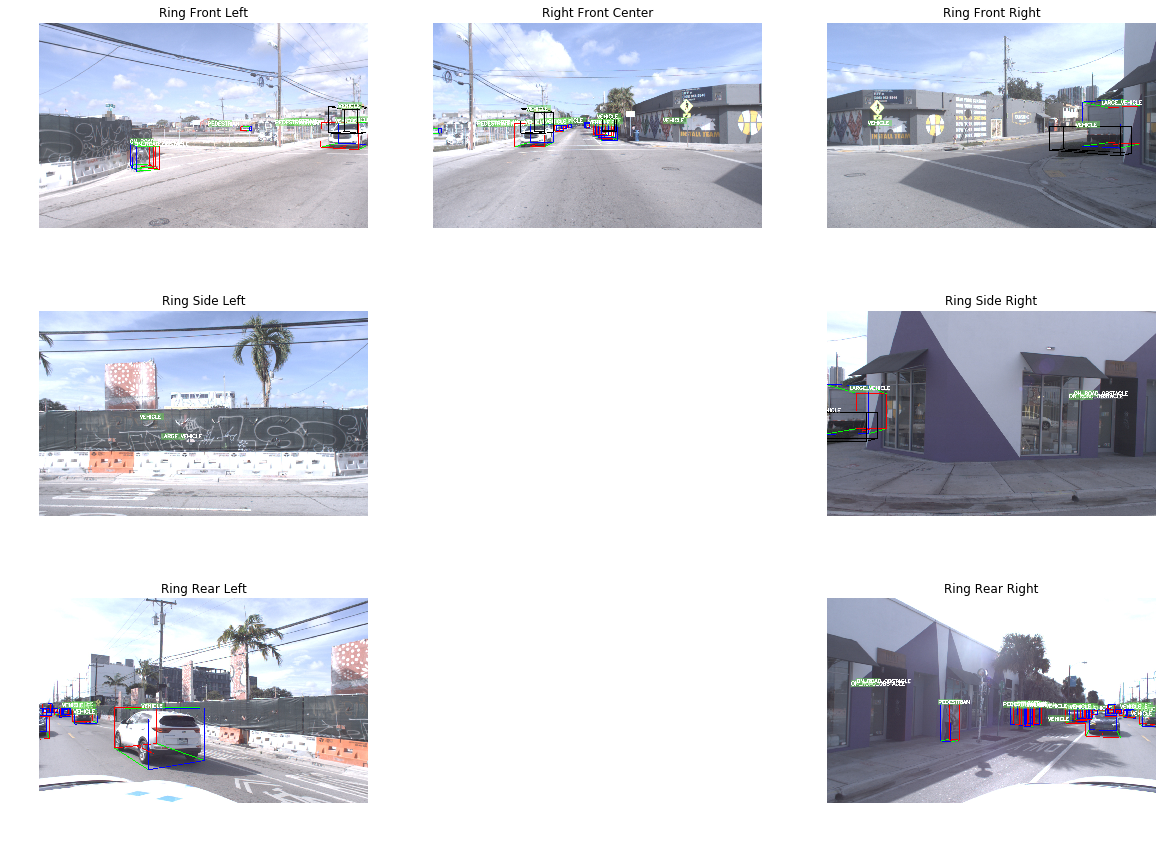

In [35]:
pred_labels = [lbl.json_label_dict_to_obj_record(detect_res[k]) for k in range(len(detect_res))]
f, ax3 = make_grid_ring_camera2(data, 0, pred_labels)
plt.show()

## Visualize trajectory

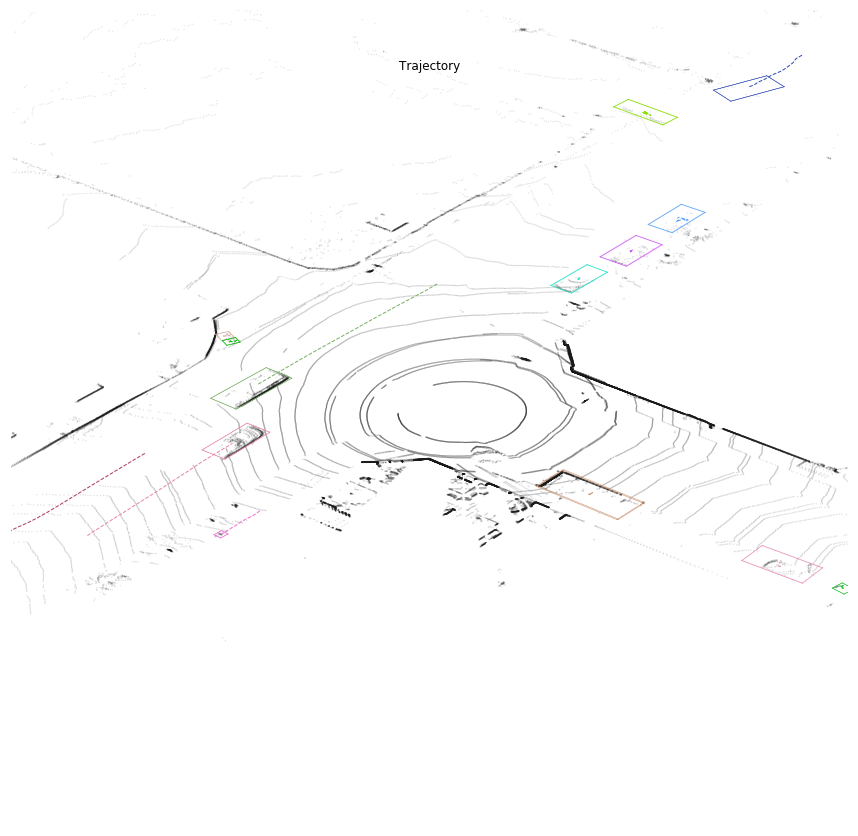

In [38]:
data = loader.get(curr_log)
idx = 30 # current time frame

f3 = plt.figure(figsize=(15, 15))
ax3 = f3.add_subplot(111, projection='3d')  
viz_util.draw_point_cloud_trajectory(
        ax3, 
        'Trajectory', 
        data, idx, 
        axes=[0, 1], xlim3d=(-15,15), ylim3d=(-15,15) # X and Y axes
    )
plt.axis('off')
plt.show()

In [49]:
point_size = 0.01
axes_limits = [
    [-10, 10],
    [-10, 10],
    [-3, 10],
]  # X axis range  # Y axis range  # Z axis range
axes_str = ["X", "Y", "Z"]

_COLOR_MAP = [
    (float(np.random.rand()), float(np.random.rand()), float(np.random.rand()))
    for i in range(len(OBJ_CLASS_MAPPING_DICT) + 1)
]


def draw_point_cloud_trajectory2(
    ax,
    title: str,
    argoverse_data: ArgoverseTrackingLoader,
    idx: int,
    axes: Optional[Any] = None,
    xlim3d: Any = None,
    ylim3d: Any = None,
    zlim3d: Any = None,
    track_res = track_res
):
    #axes = _get_axes_or_default(axes)
    unique_id_list = set()
    for i in range(len(argoverse_data.lidar_list)):
        for label in argoverse_data.get_label_object(i):
            unique_id_list.add(label.track_id)
    color_map = {
        track_id: (
            float(np.random.rand()),
            float(np.random.rand()),
            float(np.random.rand()),
        )
        for track_id in unique_id_list
    }
    pc = argoverse_data.get_lidar(idx)
    assert isinstance(pc, np.ndarray)
    objects = argoverse_data.get_label_object(idx)
    ax.scatter(*np.transpose(pc[:, axes]), s=point_size, c=pc[:, 2], cmap="gray")
    ax.set_title(title)
    ax.set_xlabel("{} axis".format(axes_str[axes[0]]))
    ax.set_ylabel("{} axis".format(axes_str[axes[1]]))
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.set_zlabel("{} axis".format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
    if xlim3d != None:
        ax.set_xlim3d(xlim3d)
    if ylim3d != None:
        ax.set_ylim3d(ylim3d)
    if zlim3d != None:
        ax.set_zlim3d(zlim3d)
    visible_track_id = set()
    for obj in objects:
        if obj.occlusion == 100:
            continue
        viz_util.draw_box(ax, obj.as_3d_bbox().T, axes=axes, color=color_map[obj.track_id])

        visible_track_id.add(obj.track_id)

        
    # visualize true trajectory
    current_pose = argoverse_data.get_pose(idx)
    traj_by_id: Dict[Optional[str], List[Any]] = defaultdict(list)
    traj_by_id_pred: Dict[Optional[str], List[Any]] = defaultdict(list)
    for i in range(0, idx, 1):
        if current_pose is None:
            logger.warning("`current_pose` is missing at index %d", idx)
            break

        pose = argoverse_data.get_pose(i)
        if pose is None:
            logger.warning("`pose` is missing at index %d", i)
            continue

        objects = argoverse_data.get_label_object(i)
        for obj in objects:
            if obj.occlusion == 100:
                continue
            if obj.track_id is None or obj.track_id not in visible_track_id:
                continue
            x, y, z = pose.transform_point_cloud(np.array([np.array(obj.translation)]))[0]

            x, y, _ = current_pose.inverse_transform_point_cloud(np.array([np.array([x, y, z])]))[0]
            # ax.scatter(x,y, s=point_size, c=color_map[obj.track_id])
            if obj.track_id is None:
                logger.warning("Label has no track_id.  Collisions with other tracks that are missing IDs could happen")

            traj_by_id[obj.track_id].append([x, y])
        
        
        pred_jsons = track_res[i]
        for pobj in pred_jsons:
            pobj_label = lbl.json_label_dict_to_obj_record(pobj)
            #print(pobj_label)
            xp, yp, zp = pose.transform_point_cloud(np.array([np.array(pobj_label.translation)]))[0]
            xp, yp, _ = current_pose.inverse_transform_point_cloud(np.array([np.array([xp, yp, zp])]))[0]

            traj_by_id_pred[pobj_label.track_id].append([xp, yp])
            

    for track_id in traj_by_id.keys():
        traj = np.array(traj_by_id[track_id])
        ax.plot(
            traj[:, 0],
            traj[:, 1],
            color=color_map[track_id],
            linestyle="--",
            linewidth=1,
        )
        
    for track_id in traj_by_id_pred.keys():
        traj = np.array(traj_by_id_pred[track_id])
        ax.plot(
            traj[:, 0],
            traj[:, 1],
            color='black',
            linestyle="--",
            linewidth=1,
        )

In [50]:
track_res = [json.load(open(track_dir + track_files[k], 'rb')) for k in range(len(track_files))]

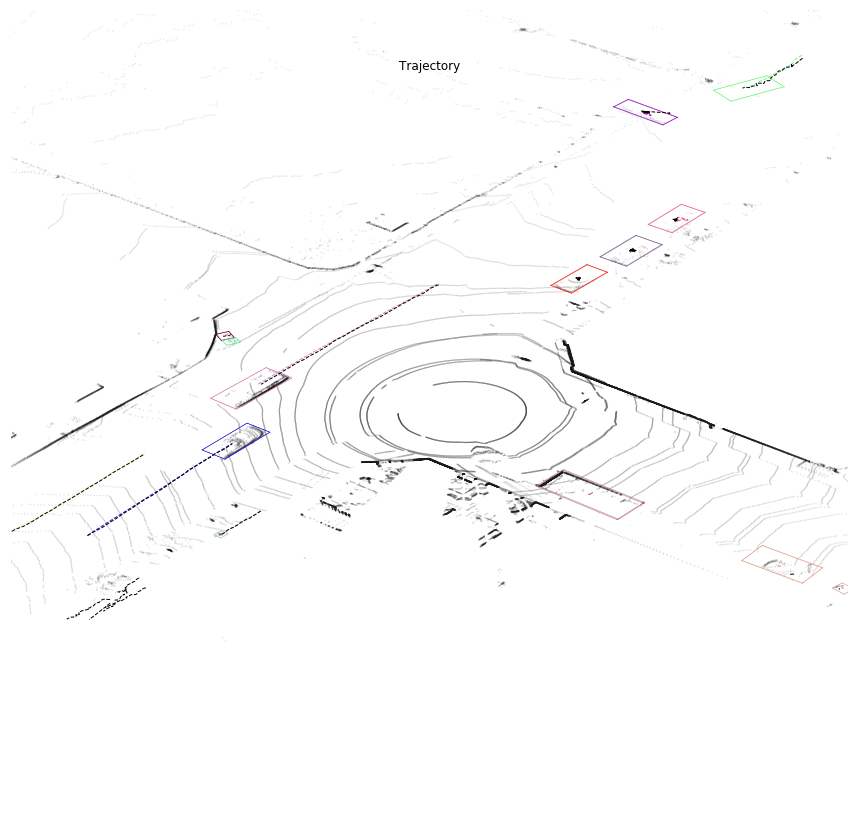

In [51]:
f4 = plt.figure(figsize=(15, 15))
ax4 = f4.add_subplot(111, projection='3d')  
draw_point_cloud_trajectory2(
        ax4, 
        'Trajectory', 
        data, idx, 
        axes=[0, 1], xlim3d=(-15,15), ylim3d=(-15,15), # X and Y axes
    )
plt.axis('off')
plt.show()

# Format transformation for Point RCNN detection

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from tqdm import tqdm
from collections import Counter, defaultdict
from PIL import Image
import copy
import logging
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union

from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader
from argoverse.data_loading.object_classes import OBJ_CLASS_MAPPING_DICT
from argoverse.data_loading.object_label_record import ObjectLabelRecord
from argoverse.utils.calibration import Calibration
from argoverse.utils.frustum_clipping import generate_frustum_planes

import argoverse
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader

In [36]:
master_dir = "/Users/yuqingz/Documents/Argo"
data_dir = master_dir + "/argoverse-tracking/train4"
loader = ArgoverseTrackingLoader(data_dir)

In [72]:
for i, data in enumerate(loader):
    for lidar_idx in range(len(data.lidar_list)):
        lidar_pts = data.get_lidar(lidar_idx)
        
        lidar_pts = np.append(lidar_pts, np.zeros((lidar_pts.shape[0], 1)), 
                              axis=1)
        assert lidar_pts.shape[1] == 4
        file_name = master_dir + '/ptrcnn_data/' + data.current_log + \
            '__' + str(data.lidar_timestamp_list[lidar_idx]) + '.npy'
        np.save(file_name, lidar_pts)